# Timeseries Forecasting with LSTM Neural Networks

_Authors: Kiefer Katovich (SF)_

---

### Learning Objectives
- Learn how to build a basic LSTM using Keras.
- Train the LSTM model on unemployment data and forecast to future data.
- Understand the different ways to fit the LSTM model for timeseries data.
- Understand the "stateful" LSTM setup and how it compares to the standard fitting procedure.

### Lesson Guide
- [Introduction](#introduction)
	- [A note on the lesson content](#a-note-on-the-lesson-content)
- [Load the Keras modules](#load-the-keras-modules)
- [Prepare the unemployment data for timeseries modeling](#prepare-the-unemployment-data-for-timeseries-modeling)
	- [Create the first-order differenced unemployment rate](#create-the-first-order-differenced-unemployment-rate)
	- [Normalize the differenced unemployement data with `MinMaxScaler`](#normalize-the-differenced-unemployement-data-with-minmaxscaler)
	- [Split the timeseries into 50% train/test splits](#split-the-timeseries-into--traintest-splits)
- [Write a function to create the predictor and target data](#write-a-function-to-create-the-predictor-and-target-data)
	- [Create training and testing data for a lag of 1](#create-training-and-testing-data-for-a-lag-of-)
- [Reshape the data to work with the LSTM](#reshape-the-data-to-work-with-the-lstm)
- [Constructing the Keras model](#constructing-the-keras-model)
	- [Fit the LSTM model](#fit-the-lstm-model)
	- [Plot the original data, the training predictions and the testing predictions](#plot-the-original-data-the-training-predictions-and-the-testing-predictions)
- [LSTM with multiple lags as predictors](#lstm-with-multiple-lags-as-predictors)
- [Refraing the problem using the LSTM "time steps" dimension](#refraing-the-problem-using-the-lstm-time-steps-dimension)
	- [Rebuild and fit the LSTM model, and plot the predictions](#rebuild-and-fit-the-lstm-model-and-plot-the-predictions)
- ["Stateful" LSTM models](#stateful-lstm-models)


<a id="introduction"></a>
## Introduction
---

Modeling timeseries and forecasting with neural networks is a growing trend. The Long Short Term Memory (LSTM) recurrent neural network architecture is a popular choice when "context" or memory across time is a desired capability of the model.

In this walkthrough/codealong lecture we will be building an LSTM using the Keras framework to forecast stock market timeseries data. 

<a id="a-note-on-the-lesson-content"></a>
### A note on the lesson content

This codealong focuses primarily on the Keras implementation and application of LSTM neural networks. This lecture does not cover:
- The theory behind recurrent neural networks.
- The mathematics or theory behind the architecture of LSTM networks.

There are a variety of great resources to dive deeper into LSTM networks:
- [A beginners guide to recurrent networks and LSTMs](http://deeplearning4j.org/lstm.html#a-beginners-guide-to-recurrent-networks-and-lstms)
- [Understanding LSTMs](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [This tutorial provides a great introduction to building a simple LSTM for timeseries forecasting.](http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/) which 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


<a id="prepare-the-unemployment-data-for-timeseries-modeling"></a>
## Prepare the unemployment data for timeseries modeling
---

First we will load quarterly US unemployment data to do some basic forecasting using LSTMs. 

**Load the unemployment data from CSV file and perform any required cleaning.**

In [3]:
data = pd.read_csv('data/seasonally-adjusted-quarterly-us.csv')

In [4]:
data

,Quarter,Seasonally adjusted quarterly U.S. unemployment rates from 1948 to 1993
0,1948Q1,3.733%
1,1948Q2,3.667%
2,1948Q3,3.767%
3,1948Q4,3.833%
4,1949Q1,4.667%
...,...,...
170,1990Q3,5.6%
171,1990Q4,5.9%
172,1991Q1,6.5%
173,1991Q2,6.833%


In [5]:
data.columns = ['year_quarter', 'unemployment_rate']
data['unemployment_rate'] = data['unemployment_rate'].map(lambda x: float(str(x).replace('%','')))
data.head(3)

,year_quarter,unemployment_rate
0,1948Q1,3.733
1,1948Q2,3.667
2,1948Q3,3.767


In [6]:
data = data.dropna()

In [7]:
data['year_quarter'] = data['year_quarter'].apply(lambda x: x.replace('Q1','-03-31')
                                                             .replace('Q2','-06-30')
                                                             .replace('Q3','-09-30')
                                                             .replace('Q4','-12-31'))

data['year_quarter'] = data['year_quarter'].apply(pd.to_datetime)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
data.set_index('year_quarter',inplace=True)

In [9]:
data

,unemployment_rate
year_quarter,
1948-03-31,3.733
1948-06-30,3.667
1948-09-30,3.767
1948-12-31,3.833
1949-03-31,4.667
...,...
1990-06-30,5.333
1990-09-30,5.600
1990-12-31,5.900


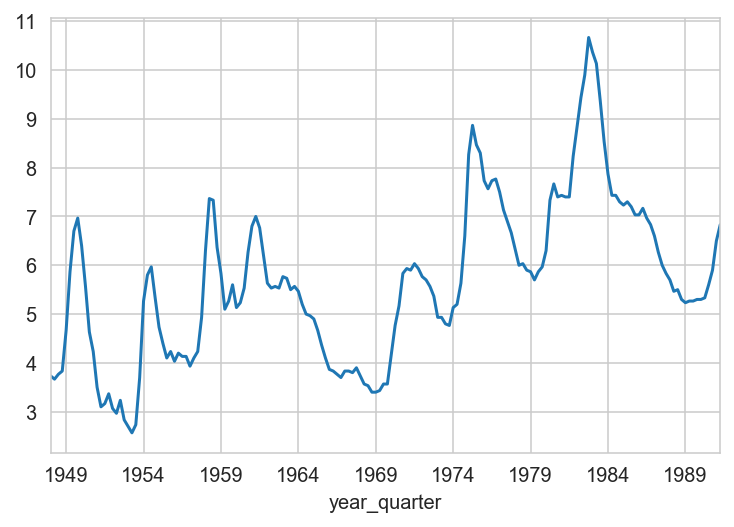

In [10]:
data['unemployment_rate'].plot()

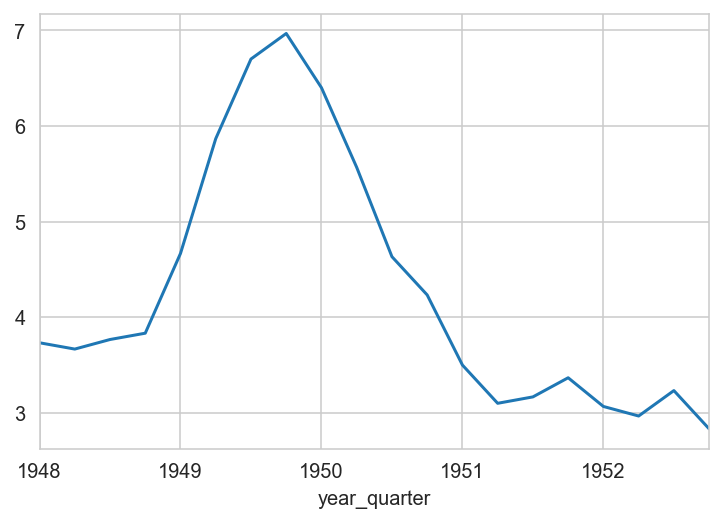

In [11]:
data['unemployment_rate'].head(4*5).plot()

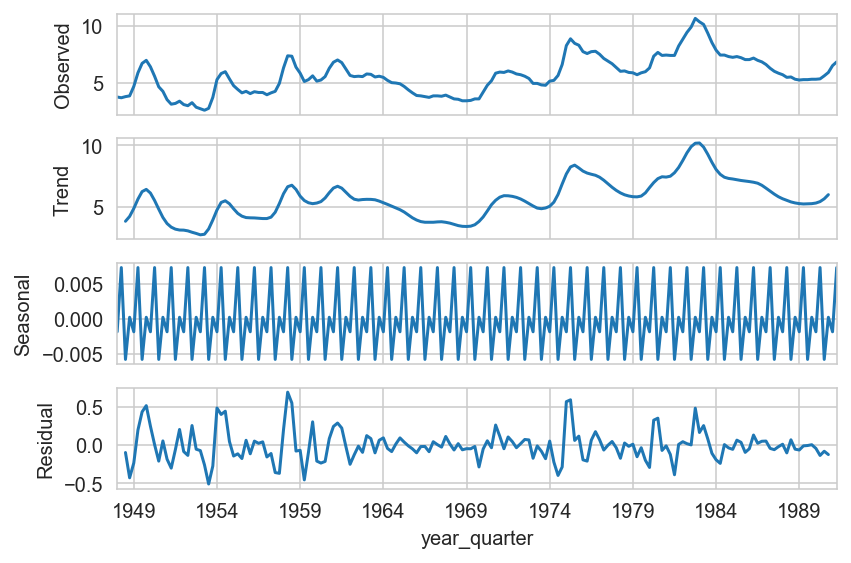

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(data['unemployment_rate'])
res.plot();

<a id="create-the-first-order-differenced-unemployment-rate"></a>
### Create the first-order differenced unemployment rate

In timeseries modeling the raw timeseries is rarely used. Typically we will use the first order differenced timeseries (or further order differences). Technically this differencing is done to ensure that the timeseries is stationary. 

However, there are more intuitive reasons why we would want to model the differences as opposed to the actual values. Take the AAPL stock price, for example, and imagine we are a day-trader. If we hold the AAPL stock, we are of course interested in having a model that can predict the price of the stock in the future. However, what we are *really* interested in is how the stock price will *change* in the future from the current point. It is more useful to say "the stock will go up by one point" than it is to say "the stock price will be 51." 

In [13]:
data['udiff'] = data['unemployment_rate'].diff(1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
data.head()

,unemployment_rate,udiff
year_quarter,,
1948-03-31,3.733,NaN
1948-06-30,3.667,-0.066
1948-09-30,3.767,0.100
1948-12-31,3.833,0.066
1949-03-31,4.667,0.834


In [15]:
data = data.dropna()

<a id="normalize-the-differenced-unemployement-data-with-minmaxscaler"></a>
### Normalize the differenced unemployement data with `MinMaxScaler`

We want the rate to be restricted to the range -1 to 1.

> **Note:** the differencing will make the first value of the series a NaN value. Make sure to drop this from the dataset.

In [16]:
urate = data[['udiff']]
mms = MinMaxScaler(feature_range=(-1, 1))
urate = mms.fit_transform(urate)
print(urate.shape)

(173, 1)


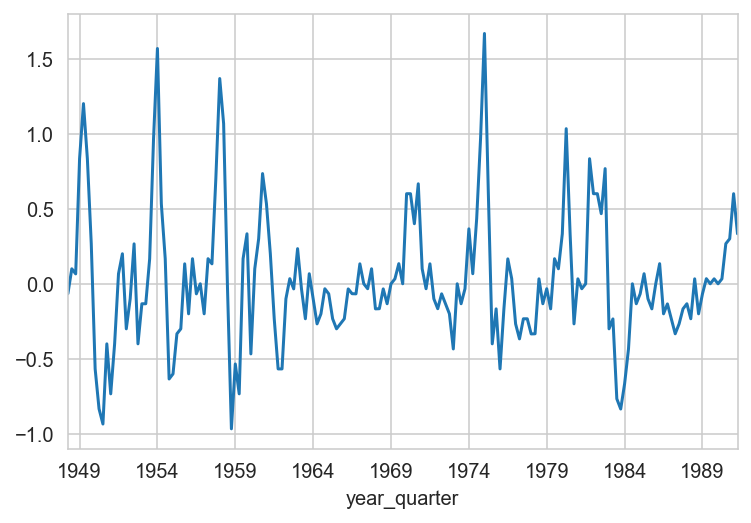

In [17]:
data['udiff'].plot()

In [65]:
type(urate)

numpy.ndarray

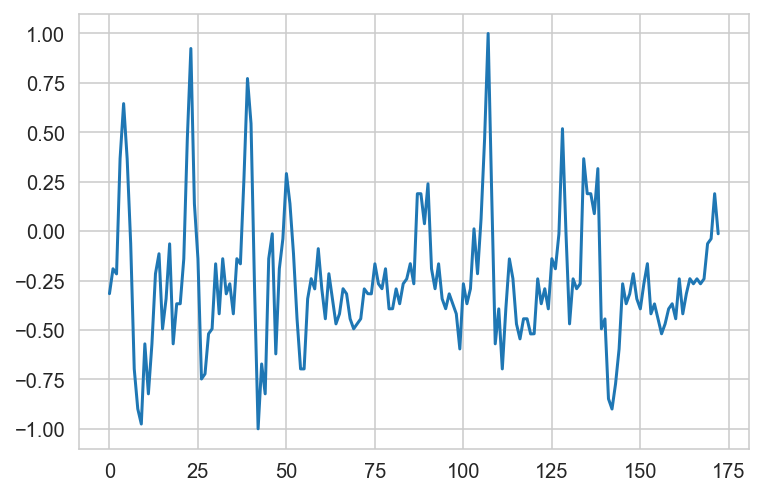

In [19]:
plt.plot(urate)

<a id="split-the-timeseries-into--traintest-splits"></a>
### Split the timeseries into 50% train/test splits

We don't want a random train/test split in this case. With timeseries data, we are interested in how are model generalizes to future data in particular. Make the test set the second half of the data through time.

In [20]:
train_size = int(len(urate) * 0.50)
test_size = len(urate) - train_size
print(len(urate), train_size, test_size)

train, test = urate[0:train_size,:], urate[train_size:len(urate),:]

173 86 87


In [66]:
print(type(train), type(test))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


<a id="write-a-function-to-create-the-predictor-and-target-data"></a>
## Write a function to create the predictor and target data
---

The function will need to create a Y target and X predictor. The X predictor matrix will simply be the shifted versions of Y, our target unemployment timeseries. In other words, we want our features to be previous timesteps of the target data for given lags.

**Make a function with two arguments:**
1. The timeseries data.
2. The number of lags of the timeseries to have as predictors.

The default should create a dataset where X is the unemployment rate a given time (t) and Y is the unemployment rate at the next time (t + 1). At the default lag of 1 X will just be the unemployment timeseries of Y shifted back by 1.

> **Note:** make sure that the output X and Y are of the same length! You will need to slice off a row (at least - depends on the lag order).

In [21]:
udiff = data.udiff

In [22]:
udiff = udiff[0:8]
udiff

year_quarter
1948-06-30   -0.066
1948-09-30    0.100
1948-12-31    0.066
1949-03-31    0.834
1949-06-30    1.200
1949-09-30    0.833
1949-12-31    0.267
1950-03-31   -0.567
Name: udiff, dtype: float64

In [23]:
pd.DataFrame(dict(y=udiff.shift(1)))

,y
year_quarter,
1948-06-30,NaN
1948-09-30,-0.066
1948-12-31,0.100
1949-03-31,0.066
1949-06-30,0.834
1949-09-30,1.200
1949-12-31,0.833
1950-03-31,0.267


In [24]:
def create_data(timeseries, lag=1, as_array=True):
    if not isinstance(timeseries, pd.Series):
        timeseries = pd.Series(timeseries.ravel())
    y = timeseries[lag:]
    X = pd.DataFrame({'lag'+str(lag-i):timeseries.shift(-i) for i in range(0, lag)}).dropna().iloc[:-1, :]
    if not as_array:
        return X, y
    else:
        return X.values, y.values

In [25]:
X, y = create_data(udiff, lag=3)

In [26]:
X

array([[-0.066,  0.1  ,  0.066],
       [ 0.1  ,  0.066,  0.834],
       [ 0.066,  0.834,  1.2  ],
       [ 0.834,  1.2  ,  0.833],
       [ 1.2  ,  0.833,  0.267]])

In [27]:
y

array([ 0.834,  1.2  ,  0.833,  0.267, -0.567])

<a id="create-training-and-testing-data-for-a-lag-of-"></a>
### Create training and testing data for a lag of 1

Again, this means our X will just have 1 column.

In [28]:
lag = 1
trainX, trainY = create_data(train, lag)
testX, testY = create_data(test, lag)

<a id="reshape-the-data-to-work-with-the-lstm"></a>
## Reshape the data to work with the LSTM
---

The format of data the LSTM expects is:

    [samples, time_steps, features]
    
Which is a 3D matrix.

We have been using 2D predictor matrices for our machine learning algorithms, where our X predictor matrix has been in the form:

    [samples, features]

Since we are working with timeseries (which is the data an LSTM expects), we are now required to provide information about the time.

You can use the `np.reshape()` command to turn your 2D X matrix into a 3D matrix that works for the LSTM matrix. We will talk about the "time step" dimension more down the line. 

> **Note:** In the case of a single lag this time step dimension is redundant. Later on, when we redesign the X matrix so that our individual features have multiple timesteps, this 3D format requirement will be clearer.

In [29]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [30]:
print(trainX.shape, trainY.shape)

(85, 1, 1) (85,)


<a id="constructing-the-keras-model"></a>
## Constructing the Keras model

Our LSTM model will be constructed in three parts.

First initialize the sequential layer-to-layer neural network model:

```python
model = Sequential()
```
    
Add an LSTM layer with 4 blocks/cells/neurons. We specify the `input_shape` to be the same dimensions as our features. You will notice that the `input_shape` below takes a tuple `(None, lag)`. The `None` is a placeholder for the timesteps of our features. By putting `None` we are simply avoiding specifying the timesteps.

```python
model.add(LSTM(4, input_shape=(None, lag)))
```

Add the output layer as a layer of one neuron that is fully connected to all of the previous LSTM cells:

```python
model.add(Dense(1))
```

In [37]:
model = Sequential()
model.add(LSTM(3, input_shape=(None, lag)))
model.add(Dense(1))

<a id="fit-the-lstm-model"></a>
### Fit the LSTM model

We can fit the model with these commands:

```python
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
```

Which will use the squared error loss (regression) and fit the data over 100 "epochs", or passes over the training data. It makes multiple passes because these LSTM neural networks learn according to a learning rate (which we have not specified).

The `optimizer='adam'` selects the type of algorithm for gradient descent. The Adam optimizer performs well and is often recommended for many types of neural network architectures.

In [38]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=1)

Epoch 1/20
85/85 [==============================] - 0s 5ms/step - loss: 0.1941
Epoch 2/20
85/85 [==============================] - 0s 1ms/step - loss: 0.1526
Epoch 3/20
85/85 [==============================] - 0s 1ms/step - loss: 0.1274
Epoch 4/20
85/85 [==============================] - 0s 1ms/step - loss: 0.1134
Epoch 5/20
85/85 [==============================] - 0s 1ms/step - loss: 0.1051
Epoch 6/20
85/85 [==============================] - 0s 1ms/step - loss: 0.0998
Epoch 7/20
85/85 [==============================] - 0s 1ms/step - loss: 0.0955
Epoch 8/20
85/85 [==============================] - 0s 1ms/step - loss: 0.0919
Epoch 9/20
85/85 [==============================] - 0s 1ms/step - loss: 0.0890
Epoch 10/20
85/85 [==============================] - 0s 2ms/step - loss: 0.0868
Epoch 11/20
85/85 [==============================] - 0s 2ms/step - loss: 0.0846
Epoch 12/20
85/85 [==============================] - 0s 1ms/step - loss: 0.0830
Epoch 13/20
85/85 [==============================

<a id="plot-the-original-data-the-training-predictions-and-the-testing-predictions"></a>
### Plot the original data, the training predictions and the testing predictions

You can predict from a Keras model much like with a sklearn model:

```python
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
```

Make sure you lag the data forward for training and testing!

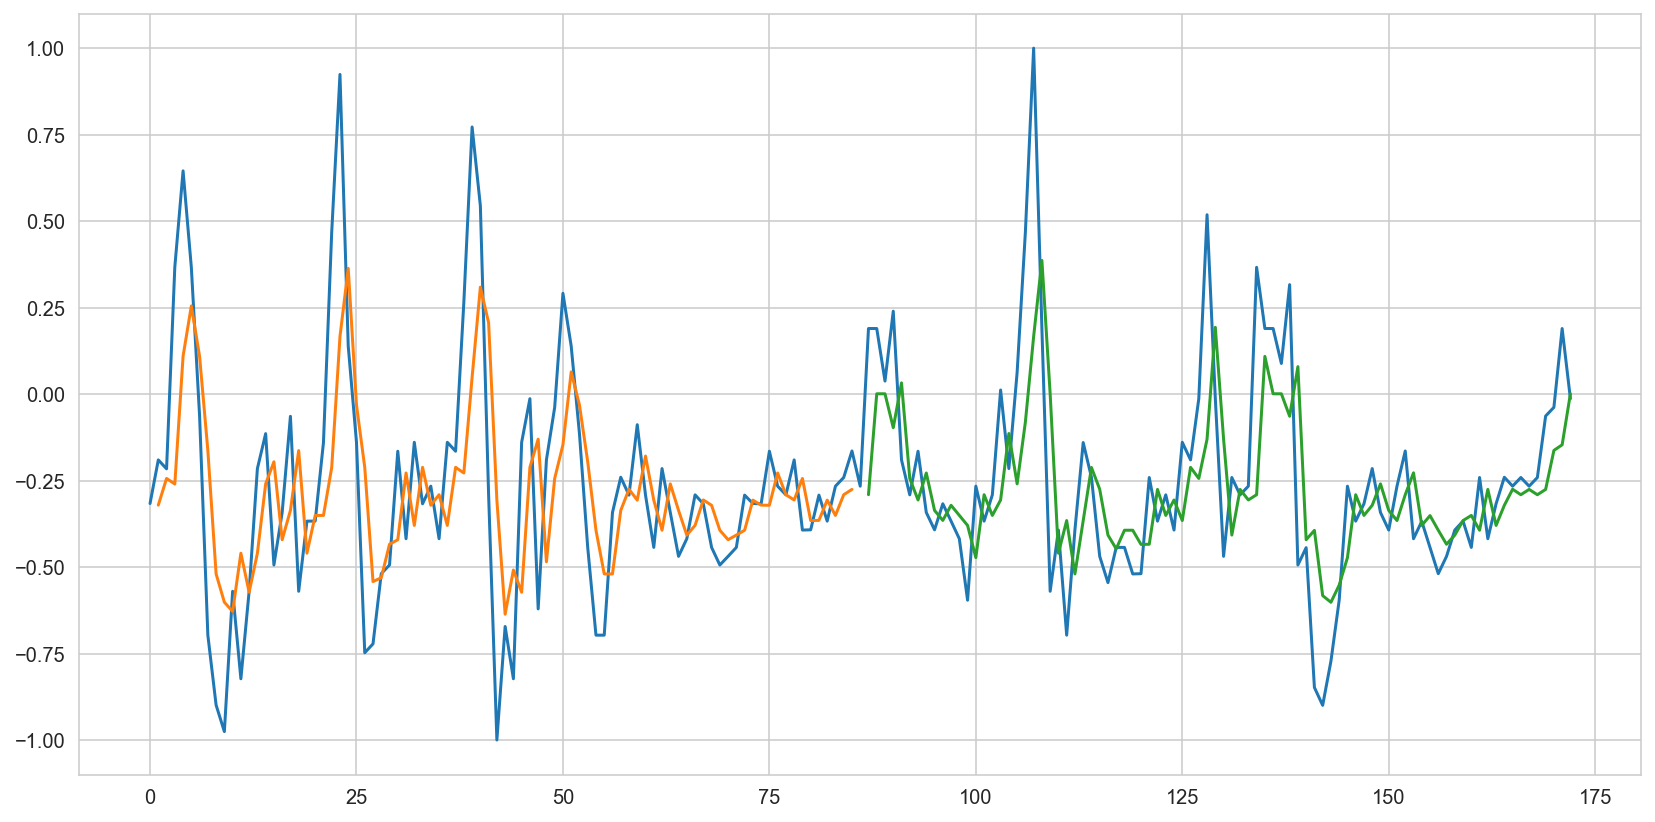

In [44]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(urate)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
 
# shift test predictions for plotting
testPredictPlot = np.empty_like(urate)
testPredictPlot[:, :] = np.nan
testPredictPlot[-len(testPredict):, :] = testPredict
 
# plot baseline and predictions
plt.figure(figsize=(14,7))
plt.plot(urate)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

<a id="lstm-with-multiple-lags-as-predictors"></a>
## LSTM with multiple lags as predictors
---

We can instead predict the unemployment rate from not just the rate prior, but the `t-1`, `t-2`, and `t-3` rates.

You can use the function you wrote above to construct a new X and y where X now has 3 predictors according to the different lags.

Create the new Y and X variables below:

In [45]:
lag = 3
trainX, trainY = create_data(train, lag)
testX, testY = create_data(test, lag)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print(trainX[0:5])

[[[-0.31636916 -0.19027725 -0.2161033 ]]

 [[-0.19027725 -0.2161033   0.36726168]]

 [[-0.2161033   0.36726168  0.64527155]]

 [[ 0.36726168  0.64527155  0.36650209]]

 [[ 0.64527155  0.36650209 -0.06342575]]]


In [46]:
model = Sequential()
model.add(LSTM(4, input_shape=(None, lag)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=1)

Epoch 1/50
83/83 [==============================] - 0s 5ms/step - loss: 0.2320
Epoch 2/50
83/83 [==============================] - 0s 1ms/step - loss: 0.1819
Epoch 3/50
83/83 [==============================] - 0s 1ms/step - loss: 0.1554
Epoch 4/50
83/83 [==============================] - 0s 1ms/step - loss: 0.1377
Epoch 5/50
83/83 [==============================] - 0s 1ms/step - loss: 0.1279
Epoch 6/50
83/83 [==============================] - 0s 1ms/step - loss: 0.1212
Epoch 7/50
83/83 [==============================] - 0s 1ms/step - loss: 0.1157
Epoch 8/50
83/83 [==============================] - 0s 1ms/step - loss: 0.1108
Epoch 9/50
83/83 [==============================] - 0s 1ms/step - loss: 0.1064
Epoch 10/50
83/83 [==============================] - 0s 1ms/step - loss: 0.1024
Epoch 11/50
83/83 [==============================] - 0s 1ms/step - loss: 0.0985
Epoch 12/50
83/83 [==============================] - 0s 1ms/step - loss: 0.0952
Epoch 13/50
83/83 [==============================

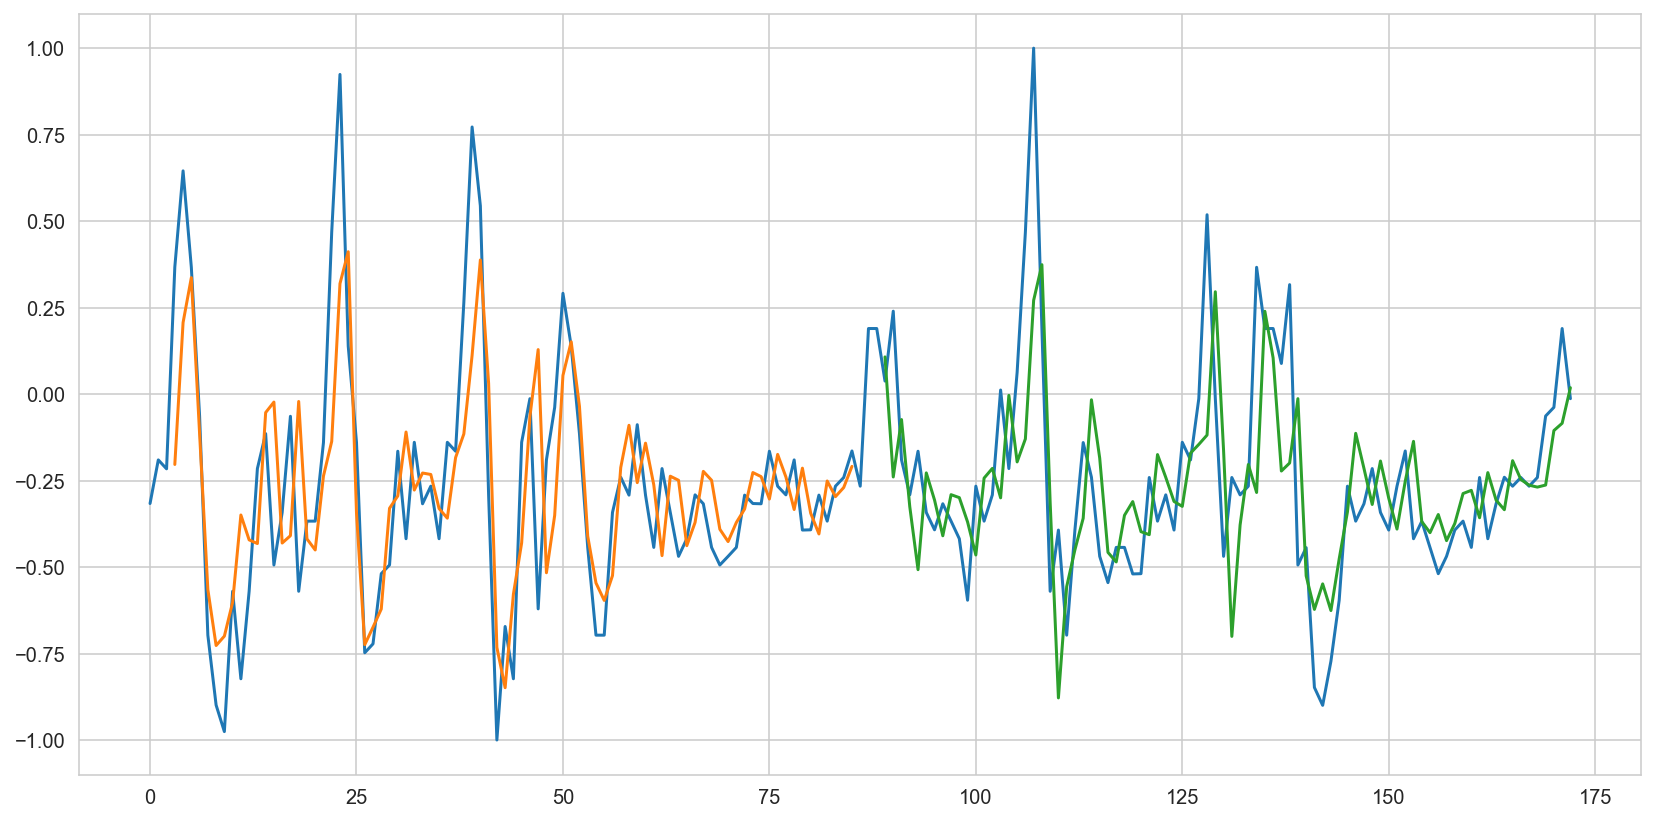

In [48]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(urate)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
 
# shift test predictions for plotting
testPredictPlot = np.empty_like(urate)
testPredictPlot[:, :] = np.nan
testPredictPlot[-len(testPredict):, :] = testPredict
 
# plot baseline and predictions
plt.figure(figsize=(14,7))
plt.plot(urate)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

<a id="refraing-the-problem-using-the-lstm-time-steps-dimension"></a>
## Refraing the problem using the LSTM "time steps" dimension
---

Recall that our X matrix is converted to the form:

    [samples, time steps, features]
    
In the model we just made, we were saying that we had 3 different features, each of 1 time step long. This works fine, but it would be more appropriate to say that we had 1 feature with three different time steps, since that's what the data actually is (the unemplyment rate lagged to different degrees).

Instead of reshaping our data where the time step dimension is 1, we can instead reshape it so that the feature dimension is 1 and the time step dimension is 3, like so:

```python
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
```

In this toy example, this will for all intents and purposes be the same, but it is more appropriate to specify it this way since the variable is the same.

Recreate your training and testing data but reshaping your lags on the time dimension rather than the feature dimension:

In [55]:
lag = 5
trainX, trainY = create_data(train, lag)
testX, testY = create_data(test, lag)

In [56]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [57]:
print(trainX.shape)

(81, 5, 1)


<a id="rebuild-and-fit-the-lstm-model-and-plot-the-predictions"></a>
### Rebuild and fit the LSTM model, and plot the predictions

You will need to change the `input_shape` now to be `input_shape=(lag, 1)`, which indicates we have "lag" number of timesteps and 1 predictor/feature.

In [58]:
model = Sequential()
model.add(LSTM(4, input_shape=(lag, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=1)

Epoch 1/50
81/81 [==============================] - 1s 6ms/step - loss: 0.1457
Epoch 2/50
81/81 [==============================] - 0s 2ms/step - loss: 0.1109
Epoch 3/50
81/81 [==============================] - 0s 2ms/step - loss: 0.1066
Epoch 4/50
81/81 [==============================] - 0s 2ms/step - loss: 0.1025
Epoch 5/50
81/81 [==============================] - 0s 2ms/step - loss: 0.0996
Epoch 6/50
81/81 [==============================] - 0s 2ms/step - loss: 0.0962
Epoch 7/50
81/81 [==============================] - 0s 2ms/step - loss: 0.0929
Epoch 8/50
81/81 [==============================] - 0s 3ms/step - loss: 0.0903
Epoch 9/50
81/81 [==============================] - 0s 2ms/step - loss: 0.0869
Epoch 10/50
81/81 [==============================] - 0s 3ms/step - loss: 0.0832
Epoch 11/50
81/81 [==============================] - 0s 2ms/step - loss: 0.0808
Epoch 12/50
81/81 [==============================] - 0s 2ms/step - loss: 0.0788
Epoch 13/50
81/81 [==============================

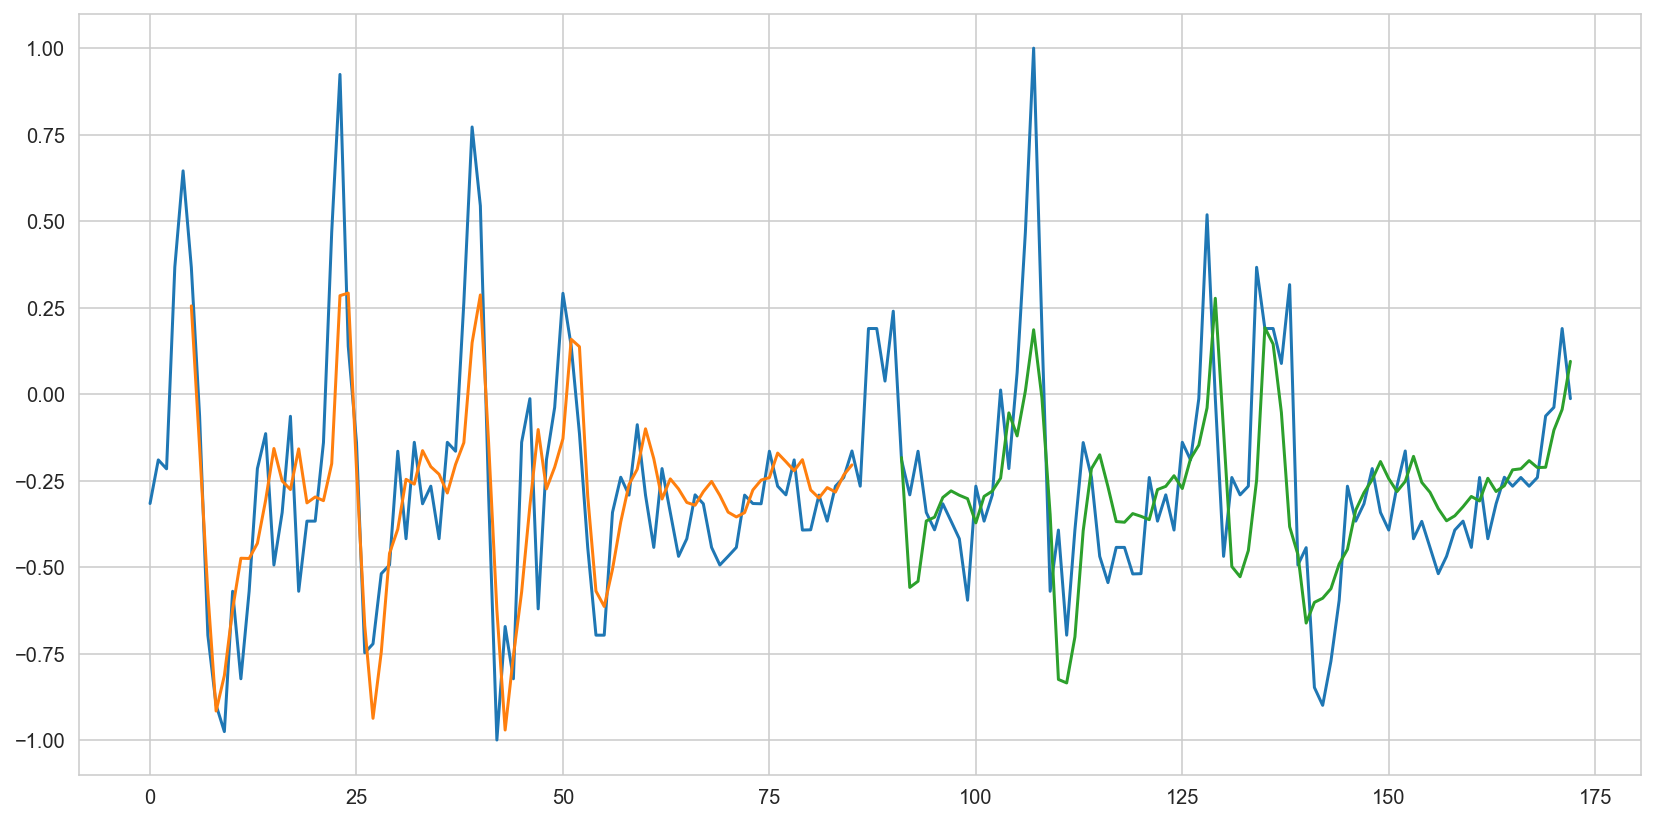

In [59]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(urate)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
 
# shift test predictions for plotting
testPredictPlot = np.empty_like(urate)
testPredictPlot[:, :] = np.nan
testPredictPlot[-len(testPredict):, :] = testPredict
 
# plot baseline and predictions
plt.figure(figsize=(14,7))
plt.plot(urate)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

<a id="stateful-lstm-models"></a>
## "Stateful" LSTM models
---

There is another even more appropriate way we can construct this LSTM model. Right now we are restricting the model to use the previous 3 timesteps only, but wouldn't it be better to allow the model to "remember" *all* of the previous timesteps? How would we do this?

LSTM models in Keras can be set as "stateful". This means that instead of resetting their internal state after each training batch, the internal state of the neurons is maintained. We can use this to our advantage to have the LSTM maintain a memory of all the previous timesteps as it fits:
1. Build the X and y data with lag 1.
2. Reshape the data to be 3D.
3. Set the batch size to 1 (this means that only 1 observation will be fed into the model at a time.)
4. Construct the LSTM model with a stateful LSTM layer.
5. Fit the model multiple times setting `nb_ephoch=1`, `shuffle=False`, and `batch_size=1`. This will go through the observations sequentially till the end, feeding them into the model one by one.
6. At the end of each iteration through all the data, call `model.reset_states()` to reset the internal state manually for the next iteration through.

The code to do this is outlined below:

In [60]:
lag = 1
trainX, trainY = create_data(train, lag)
testX, testY = create_data(test, lag)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [61]:
trainX.shape

(85, 1, 1)

In [62]:
# create and fit the LSTM network
batch_size = 1
model = Sequential()
# You will now give it a "batch_input_shape" and specify the batch size
model.add(LSTM(4, batch_input_shape=(batch_size, lag, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [63]:
for i in range(20):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()

Epoch 1/1
85/85 [==============================] - 0s 4ms/step - loss: 0.1798
Epoch 1/1
85/85 [==============================] - 0s 1ms/step - loss: 0.1359
Epoch 1/1
85/85 [==============================] - 0s 950us/step - loss: 0.1249
Epoch 1/1
85/85 [==============================] - 0s 1ms/step - loss: 0.1224
Epoch 1/1
85/85 [==============================] - 0s 966us/step - loss: 0.1203
Epoch 1/1
85/85 [==============================] - 0s 1ms/step - loss: 0.1182
Epoch 1/1
85/85 [==============================] - 0s 964us/step - loss: 0.1161
Epoch 1/1
85/85 [==============================] - 0s 1ms/step - loss: 0.1141
Epoch 1/1
85/85 [==============================] - 0s 1ms/step - loss: 0.1121
Epoch 1/1
85/85 [==============================] - 0s 989us/step - loss: 0.1101
Epoch 1/1
85/85 [==============================] - 0s 1ms/step - loss: 0.1081
Epoch 1/1
85/85 [==============================] - 0s 984us/step - loss: 0.1060
Epoch 1/1
85/85 [==============================] - 0s 

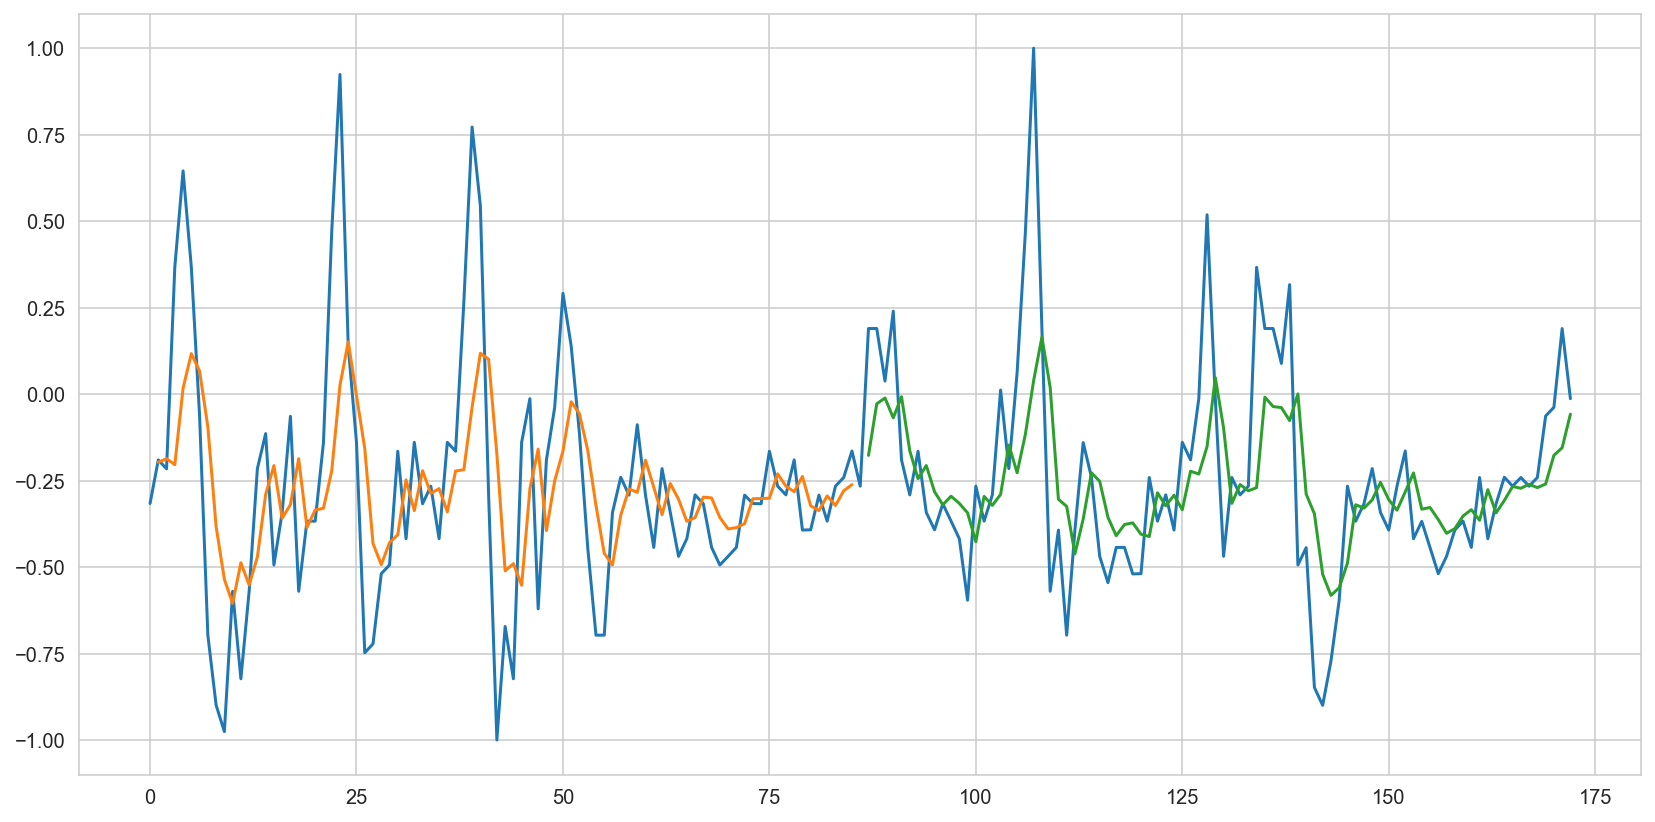

In [64]:
# generate predictions for training
# You need to reset the states manually for prediction with a stateful LSTM!!
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
model.reset_states()

# shift train predictions for plotting
trainPredictPlot = np.empty_like(urate)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
 
# shift test predictions for plotting
testPredictPlot = np.empty_like(urate)
testPredictPlot[:, :] = np.nan
testPredictPlot[-len(testPredict):, :] = testPredict
 
# plot baseline and predictions
plt.figure(figsize=(14,7))
plt.plot(urate)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Text Prediction with LSTMs

Adapted from https://www.tensorflow.org/tutorials/text/text_generation

In [67]:
import tensorflow as tf

import numpy as np
import os
import time

In [68]:
print(tf.__version__)

2.1.0


In [69]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print ('Length of text: {} characters'.format(len(text)))

Length of text: 1115394 characters


In [70]:
type(text)

str

In [71]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [73]:
# The unique characters in the file
vocab = sorted(set(text))
print('{} unique characters'.format(len(vocab)))

65 unique characters


In [74]:
vocab

['\n',
 ' ',
 '!',
 '$',
 '&',
 "'",
 ',',
 '-',
 '.',
 '3',
 ':',
 ';',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [75]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

In [76]:
print('{')
for char in list(char2idx)[:20]:
    print(f'  {repr(char):4}: {char2idx[char]:3},')
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '$' :   3,
  '&' :   4,
  "'" :   5,
  ',' :   6,
  '-' :   7,
  '.' :   8,
  '3' :   9,
  ':' :  10,
  ';' :  11,
  '?' :  12,
  'A' :  13,
  'B' :  14,
  'C' :  15,
  'D' :  16,
  'E' :  17,
  'F' :  18,
  'G' :  19,
  ...
}


In [77]:
type(char2idx)

dict

In [78]:
# Show how the first 13 characters from the text are mapped to integers
print ('{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

'First Citizen' ---- characters mapped to int ---- > [18 47 56 57 58  1 15 47 58 47 64 43 52]


In [79]:
len(text)

1115394

In [80]:
len(text_as_int)

1115394

In [84]:
# The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
    print(idx2char[i.numpy()], i.numpy())

F 18
i 47
r 56
s 57
t 58


In [87]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
    print('\n'+'*'*20+'\n')
    print(''.join(idx2char[item.numpy()]))


********************

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You 

********************

are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you k

********************

now Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us ki

********************

ll him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be d

********************

one: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citi


In [88]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [89]:
for input_example, target_example in  dataset.take(1):
    print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
    print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target data: 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [90]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step    0
  input: 18 ('F')
  expected output: 47 ('i')
Step    1
  input: 47 ('i')
  expected output: 56 ('r')
Step    2
  input: 56 ('r')
  expected output: 57 ('s')
Step    3
  input: 57 ('s')
  expected output: 58 ('t')
Step    4
  input: 58 ('t')
  expected output: 1 (' ')


In [91]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

In [104]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 50

# Number of RNN units
rnn_units = 100

In [105]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                    batch_input_shape=[BATCH_SIZE, None]))
model.add(tf.keras.layers.GRU(rnn_units,
                              return_sequences=True,
                              stateful=True,
                              recurrent_initializer='glorot_uniform'))
model.add(tf.keras.layers.Dense(vocab_size))

In [107]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (64, None, 50)            3250      
_________________________________________________________________
gru_1 (GRU)                  (64, None, 100)           45600     
_________________________________________________________________
dense_1 (Dense)              (64, None, 65)            6565      
Total params: 55,415
Trainable params: 55,415
Non-trainable params: 0
_________________________________________________________________


In [108]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 65) # (batch_size, sequence_length, vocab_size)


In [132]:
input_example_batch.shape

TensorShape([64, 100])

In [133]:
target_example_batch.shape

TensorShape([64, 100])

In [109]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (64, None, 50)            3250      
_________________________________________________________________
gru_1 (GRU)                  (64, None, 100)           45600     
_________________________________________________________________
dense_1 (Dense)              (64, None, 65)            6565      
Total params: 55,415
Trainable params: 55,415
Non-trainable params: 0
_________________________________________________________________


In [110]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [111]:
sampled_indices

array([49, 31, 29, 62, 41, 23, 20, 46, 41, 24, 21, 53, 14, 18, 17, 34, 21,
       14, 34, 48, 55, 33, 64,  6, 18, 39, 12, 33, 12, 55,  4, 13, 29, 40,
       12, 26, 59, 32, 26, 14, 33,  3, 14,  4,  1, 60, 22, 35, 14, 27, 33,
        7, 48, 50, 62, 59, 10, 10,  3,  3, 45, 43, 46, 22,  5, 40, 29,  3,
       24, 21, 25, 21, 17, 11, 22,  2,  4, 34, 61, 54, 10, 16, 31,  8, 60,
       14, 63, 15, 42, 51, 28, 46, 12, 24, 20,  0, 29, 61,  5, 40])

In [112]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

Input: 
 "or't!\n\nANGELO:\nNow, what's the matter. Provost?\n\nProvost:\nIs it your will Claudio shall die tomorrow"

Next Char Predictions: 
 "kSQxcKHhcLIoBFEVIBVjqUz,Fa?U?q&AQb?NuTNBU$B& vJWBOU-jlxu::$$gehJ'bQ$LIMIE;J!&Vwp:DS.vByCdmPh?LH\nQw'b"


In [113]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 65)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.17581


In [114]:
model.compile(optimizer='adam', loss=loss)

In [115]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [116]:
EPOCHS = 10
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Train for 172 steps
Epoch 1/10
172/172 [==============================] - 11s 63ms/step - loss: 3.0907
Epoch 2/10
172/172 [==============================] - 10s 61ms/step - loss: 2.3739 1s
Epoch 3/10
172/172 [==============================] - 10s 59ms/step - loss: 2.1823
Epoch 4/10
172/172 [==============================] - 10s 56ms/step - loss: 2.0501
Epoch 5/10
172/172 [==============================] - 11s 61ms/step - loss: 1.9544
Epoch 6/10
172/172 [==============================] - 10s 56ms/step - loss: 1.8827
Epoch 7/10
172/172 [==============================] - 9s 55ms/step - loss: 1.8271
Epoch 8/10
172/172 [==============================] - 9s 54ms/step - loss: 1.7836
Epoch 9/10
172/172 [==============================] - 11s 64ms/step - loss: 1.7479
Epoch 10/10
172/172 [==============================] - 10s 59ms/step - loss: 1.7194


In [117]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/ckpt_10'

In [134]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [135]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [136]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 50)             3250      
_________________________________________________________________
gru_2 (GRU)                  (1, None, 100)            45600     
_________________________________________________________________
dense_2 (Dense)              (1, None, 65)             6565      
Total params: 55,415
Trainable params: 55,415
Non-trainable params: 0
_________________________________________________________________


In [145]:
def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 1000

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperatures results in more predictable text.
    # Higher temperatures results in more surprising text.
    # Experiment to find the best setting.
    temperature = 1.2

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)
  
        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
  
        # We pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)
  
        text_generated.append(idx2char[predicted_id])
  
    return (start_string + ''.join(text_generated))

In [146]:
print(generate_text(model, start_string=u"ROMEO: "))

ROMEO: Nepperilesh frievome ormil; by me undievingays
Bosway une, a fost dowe
Hit me it neverave way.

HATRAUSESS LARDUCHARCEHIO: 'pas, Vird.
Anay thou, no stown prestice, 'ellow, well at's ginees lords, that veratoted;
And.
Mome,
Shall in my and me'th caunding
Cordalls of I lisss.

CETHONTULLIUS:
O shale draves?

LUCFRIUS:
Herewisondsty wills to she him,.
Cear!
As our great.

FOTY CFIANZEL:
Bunter
oug gake.

KING RICHARD VIARDETES:
I knewith Gilly, stakession!
Orty Traeands:
Getold tha! A rigrucks. Cancion took'd, the EK:
Whun, was gaver croved revere. diog: his imar;
Tamed up bringl:
The ele's sweeming, thou wepe to of a wreich,--
But thee. Would.
nom bein truperous see,
This in
dny ifless?
O vantrirsigm?
Brenkel?

ETCAUSES:
Shall-bloch thou, marry,
No'tilave, have gevelsear not, 3ix, hir? sir, the joke confult coustaceand don in:
Agling taght; we doffy:
Whowe them with
Yourrarders
Times, before, do;
But till eesinomba, they earTe tine.
Ho Maeset like?

ES:
Or Englictin.
O, 'thain hi